In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [6]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("AAPL", start="2018-01-01").reset_index()
df_full.to_csv('aapl.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,41.310070,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,41.302879,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.494736,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.967163,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.811283,82271200


Define the Q-Learning Agent
The first function is the Agent class defines the state size, window size, batch size, deque which is the memory used, inventory as a list. It also defines some static variables like epsilon, decay, gamma, etc. Two neural network layers are defined for the buy, hold, and sell call. The GradientDescentOptimizer is also used.

The Agent has functions defined for buy and sell options. The get_state and act function makes use of the Neural network for generating the next state of the neural network. The rewards are subsequently calculated by adding or subtracting the value generated by executing the call option. The action taken at the next state is influenced by the action taken on the previous state. 1 refers to a Buy call while 2 refers to a Sell call. In every iteration, the state is determined on the basis of which an action is taken which will either buy or sell some stocks. The overall rewards are stored in the total profit variable.

In [36]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.states_sell = []
        self.states_buy = []
        self.total_gains = None
        self.invest = None
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost)
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(self.sess.run(self.logits, feed_dict = {self.X: state})[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                self.states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                self.states_sell.append(t)
                try:
                    self.invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    self.invest = 0
                print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'% (t, close[t], self.invest, initial_money))
            state = next_state
        self.invest = ((initial_money - starting_money) / starting_money) * 100
        self.total_gains = initial_money - starting_money
        return self.states_buy, self.states_sell, self.total_gains, self.invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,starting_money))
                

In [37]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, window_size = window_size, trend = close, skip = skip, batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 3095.119987.3, cost: 0.302902, total money: 6432.170006
epoch: 20, total rewards: 906.212513.3, cost: 0.088455, total money: 8759.152523
epoch: 30, total rewards: 579.214973.3, cost: 0.045220, total money: 9938.174980
epoch: 40, total rewards: 197.277481.3, cost: 0.040249, total money: 9556.237488
epoch: 50, total rewards: 134.044998.3, cost: 0.032761, total money: 9865.115005
epoch: 60, total rewards: 84.694977.3, cost: 0.028523, total money: 9815.764984
epoch: 70, total rewards: 84.209991.3, cost: 0.036368, total money: 10084.209991
epoch: 80, total rewards: 79.739998.3, cost: 0.022244, total money: 10079.739998
epoch: 90, total rewards: 94.649982.3, cost: 0.021620, total money: 9960.149982
epoch: 100, total rewards: 101.034977.3, cost: 0.020507, total money: 9966.534977
epoch: 110, total rewards: 86.372490.3, cost: 0.020196, total money: 10086.372490
epoch: 120, total rewards: 106.364990.3, cost: 0.019241, total money: 10106.364990
epoch: 130, total rewards

In [53]:
states_buy = agent.buy(initial_money).states_buy
states_sell = agent.buy(initial_money).states_sell
total_gains = agent.buy(initial_money).total_gains
invest = agent.buy(initial_money).invest

day 17: buy 1 unit at price 42.877499, total balance 9957.122501
day 20, sell 1 unit at price 41.857498, investment -2.378871 %, total balance 9998.980000,
day 23: buy 1 unit at price 39.122501, total balance 9959.857498
day 24: buy 1 unit at price 40.757500, total balance 9919.099998
day 25, sell 1 unit at price 39.884998, investment 1.948998 %, total balance 9958.984997,
day 26, sell 1 unit at price 38.787498, investment -4.833469 %, total balance 9997.772495,
day 43: buy 1 unit at price 44.167500, total balance 9953.604996
day 48, sell 1 unit at price 44.992500, investment 1.867891 %, total balance 9998.597496,
day 49: buy 1 unit at price 44.610001, total balance 9953.987495
day 50: buy 1 unit at price 44.662498, total balance 9909.324997
day 51, sell 1 unit at price 44.505001, investment -0.235372 %, total balance 9953.829998,
day 53: buy 1 unit at price 43.810001, total balance 9910.019997
day 54, sell 1 unit at price 42.817501, investment -4.130977 %, total balance 9952.837498,
d

day 355, sell 1 unit at price 43.325001, investment -7.127547 %, total balance 9960.562489,
day 356: buy 1 unit at price 44.910000, total balance 9915.652489
day 357, sell 1 unit at price 45.634998, investment 2.909002 %, total balance 9961.287487,
day 359: buy 1 unit at price 47.537498, total balance 9913.749989
day 373, sell 1 unit at price 49.935001, investment 11.189048 %, total balance 9963.684990,
day 376, sell 1 unit at price 50.682499, investment 6.615831 %, total balance 10014.367489,
day 380: buy 1 unit at price 50.310001, total balance 9964.057487
day 381: buy 1 unit at price 50.807499, total balance 9913.249989
day 382: buy 1 unit at price 50.437500, total balance 9862.812489
day 383, sell 1 unit at price 50.825001, investment 1.023652 %, total balance 9913.637489,
day 387, sell 1 unit at price 51.415001, investment 1.195694 %, total balance 9965.052490,
day 389, sell 1 unit at price 51.805000, investment 2.711277 %, total balance 10016.857491,
day 392: buy 1 unit at price 

day 674: buy 1 unit at price 120.959999, total balance 9953.767487
day 676, sell 1 unit at price 117.320000, investment -3.009259 %, total balance 10071.087486,
day 677: buy 1 unit at price 113.489998, total balance 9957.597488
day 679: buy 1 unit at price 115.360001, total balance 9842.237488
day 681: buy 1 unit at price 112.129997, total balance 9730.107491
day 682, sell 1 unit at price 110.339996, investment -2.775576 %, total balance 9840.447487,
day 683: buy 1 unit at price 106.839996, total balance 9733.607491
day 684: buy 1 unit at price 110.080002, total balance 9623.527489
day 685: buy 1 unit at price 111.809998, total balance 9511.717491
day 686, sell 1 unit at price 107.120003, investment -7.142855 %, total balance 9618.837494,
day 688, sell 1 unit at price 112.279999, investment 0.133775 %, total balance 9731.117493,
day 689, sell 1 unit at price 114.959999, investment 7.600153 %, total balance 9846.077492,
day 691, sell 1 unit at price 115.809998, investment 5.205301 %, to

AttributeError: 'tuple' object has no attribute 'states_buy'

In [54]:
total_gains = agent.buy(initial_money).total_gains
total_gains

day 17: buy 1 unit at price 42.877499, total balance 9957.122501
day 20, sell 1 unit at price 41.857498, investment -2.378871 %, total balance 9998.980000,
day 23: buy 1 unit at price 39.122501, total balance 9959.857498
day 24: buy 1 unit at price 40.757500, total balance 9919.099998
day 25, sell 1 unit at price 39.884998, investment 1.948998 %, total balance 9958.984997,
day 26, sell 1 unit at price 38.787498, investment -4.833469 %, total balance 9997.772495,
day 43: buy 1 unit at price 44.167500, total balance 9953.604996
day 48, sell 1 unit at price 44.992500, investment 1.867891 %, total balance 9998.597496,
day 49: buy 1 unit at price 44.610001, total balance 9953.987495
day 50: buy 1 unit at price 44.662498, total balance 9909.324997
day 51, sell 1 unit at price 44.505001, investment -0.235372 %, total balance 9953.829998,
day 53: buy 1 unit at price 43.810001, total balance 9910.019997
day 54, sell 1 unit at price 42.817501, investment -4.130977 %, total balance 9952.837498,
d

day 437, sell 1 unit at price 54.705002, investment -0.968501 %, total balance 10024.132481,
day 438: buy 1 unit at price 55.992500, total balance 9968.139980
day 440: buy 1 unit at price 54.740002, total balance 9913.399979
day 441, sell 1 unit at price 55.205002, investment -1.406436 %, total balance 9968.604980,
day 442, sell 1 unit at price 56.752499, investment 3.676465 %, total balance 10025.357479,
day 446: buy 1 unit at price 57.522499, total balance 9967.834980
day 448, sell 1 unit at price 58.967499, investment 2.512060 %, total balance 10026.802479,
day 451: buy 1 unit at price 58.820000, total balance 9967.982479
day 452, sell 1 unit at price 59.102501, investment 0.480281 %, total balance 10027.084980,
day 477: buy 1 unit at price 65.445000, total balance 9961.639980
day 478, sell 1 unit at price 66.592499, investment 1.753379 %, total balance 10028.232479,
day 493: buy 1 unit at price 70.102501, total balance 9958.129978
day 495, sell 1 unit at price 70.004997, investment

day 756: buy 1 unit at price 129.410004, total balance 9986.569981
day 759, sell 1 unit at price 130.919998, investment 1.166830 %, total balance 10117.489979,
day 774: buy 1 unit at price 131.960007, total balance 9985.529972
day 776, sell 1 unit at price 134.990005, investment 2.296149 %, total balance 10120.519978,
day 780: buy 1 unit at price 136.910004, total balance 9983.609974
day 782: buy 1 unit at price 135.389999, total balance 9848.219975
day 783: buy 1 unit at price 135.130005, total balance 9713.089970
day 785: buy 1 unit at price 133.190002, total balance 9579.899967
day 788: buy 1 unit at price 129.869995, total balance 9450.029972
day 789: buy 1 unit at price 126.000000, total balance 9324.029972
day 790, sell 1 unit at price 125.860001, investment -8.070998 %, total balance 9449.889973,
day 791: buy 1 unit at price 125.349998, total balance 9324.539974
day 792: buy 1 unit at price 120.989998, total balance 9203.549976
day 793: buy 1 unit at price 121.260002, total bala

AttributeError: 'tuple' object has no attribute 'total_gains'

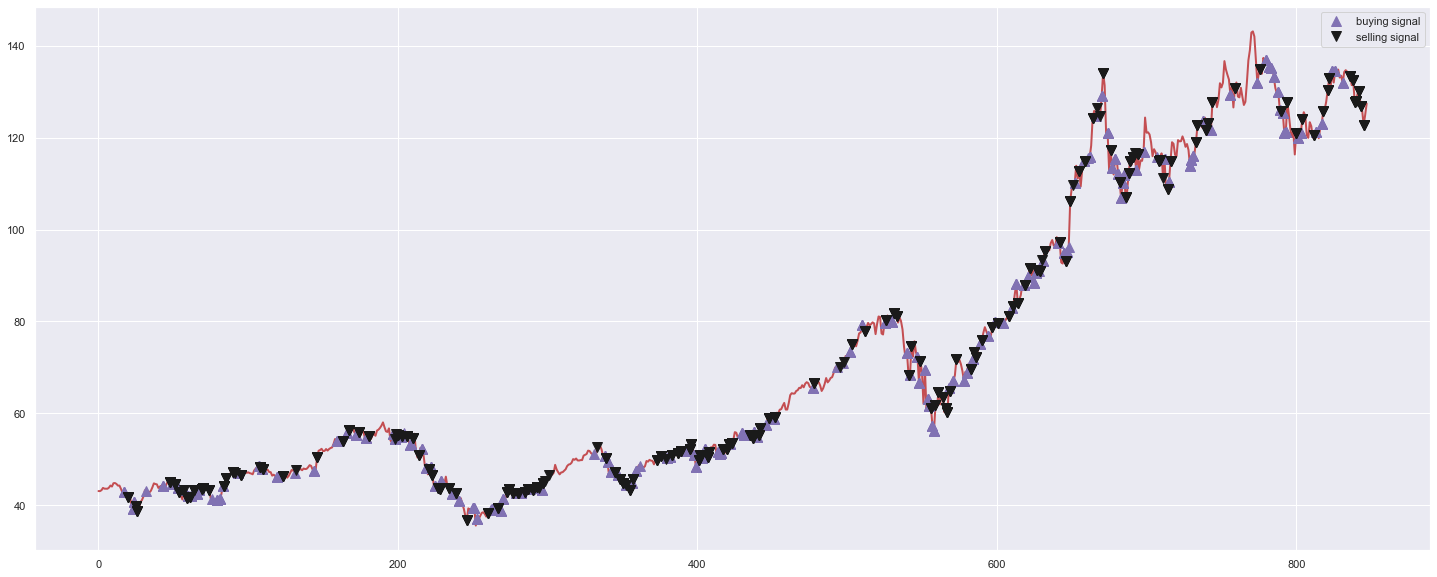

In [60]:
fig = plt.figure(figsize = (25,10))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
#plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()